## Bitcoin Sentiment Analysis

Members:
1. Choo Chee Choong(1221302637)
2. Yap Weng Hong(1211103023)


First, let's Import the necessary ibraries

In [1]:
import nltk
import pandas as pd
import re
from tqdm import tqdm
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import string
from textblob import TextBlob
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import community as community_louvain
from itertools import combinations
from nltk.wsd import lesk
import spacy 
from nltk.corpus import wordnet as wn
import requests
from spacy import displacy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, f1_score    
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

Load Dataset

In [2]:
df = pd.read_csv('Bitcoin_tweets.csv', engine='python')
print(df.shape)

(2259788, 13)


In [3]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


## Data Cleaning 
Let's check if there's any missing values. 

In [4]:
df.isnull().sum()

user_name                32
user_location       1095667
user_description     270403
user_created             99
user_followers          138
user_friends            138
user_favourites         138
user_verified           138
date                    138
text                    138
hashtags              17153
source                 3722
is_retweet              408
dtype: int64

Remove the missing values and duplicated values

In [5]:
df = df.dropna()

In [6]:
df.drop_duplicates()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False
5,ZerrBenz™ ⚔ ✪ 20732,"Bkk, Thailand",I'm a cat slave 🐱 Interested in Blockchain · T...,2010-01-12 07:00:04,742.0,716,2444,False,2021-02-10 23:53:30,💹 Trade #Crypto on #Binance \n\n📌 Enjoy #Cashb...,"['Crypto', 'Binance', 'Cashback']",Twitter Web App,False
6,Bitcoin-Bot,"Florida, USA",Bot to generate Bitcoin picture as combination...,2019-12-23 16:49:16,131.0,84,5728,False,2021-02-10 23:53:17,&lt;'fire' &amp; 'man'&gt;\n#Bitcoin #Crypto #...,"['Bitcoin', 'Crypto', 'BTC']",BTC_p_bot,False
9,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:52:08,.@Tesla’s #bitcoin investment is revolutionary...,"['bitcoin', 'crypto']",Twitter Web App,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259781,Bitcoin⚡️,Blockchain,A #Bitcoin pleb who likes to tweet about #Bitc...,2021-04-16 19:51:49,241.0,189,236,False,2022-01-19 19:08:20,The latest #bitcoin block 719497 with 142 tran...,"['bitcoin', 'Bitcoin', 'BTC', 'blockchain', 'a...",Bitcoin CMO,False
2259783,Jess Kesker💎,"California, USA",“Everything is just a game”🌸,2010-08-20 20:58:36,144.0,341,5711,False,2022-01-19 19:08:16,"#BTC even broke the $42,000 support. A clear b...",['BTC'],Twitter Web App,False
2259785,mr. decentralized,World,the decentralized is here. Now\n\nHODL #LUNA #...,2021-12-23 00:46:49,36.0,206,207,False,2022-01-19 19:08:02,The agitation at these price levels is unwarra...,"['cryptocurrency', 'cryptocrash', 'BTC', 'Ethe...",Twitter Web App,False
2259786,HODL Smaug,Lonely Montain,HODLing the $BTC Hoard since 2012. Trader / De...,2021-05-10 01:18:39,19.0,343,112,False,2022-01-19 19:07:54,Wake me when it's over. #Crypto #btc #Ethereum,"['Crypto', 'btc', 'Ethereum']",Twitter Web App,False


Let's cleans and preprocesses a random 1% sample of a dataset by removing unwanted elements from the text data (hashtags, URLs, and mentions)

In [7]:
# clean df 
df_raw = df.sort_values(by = 'date')
dd = df_raw.sample(frac=0.01, replace=False, random_state=1)
dd.reset_index(inplace=True)
for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    dd.loc[i, 'text'] = text
# save to new csv file
dd.to_csv('cleaned_file.csv', header=True, encoding='utf-8',index=False)

<>:8: SyntaxWarning: invalid escape sequence '\w'
<>:8: SyntaxWarning: invalid escape sequence '\w'
C:\Users\USER\AppData\Local\Temp\ipykernel_7440\2305903869.py:8: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
100%|██████████| 11047/11047 [00:02<00:00, 4145.30it/s]


Load cleaned dataset

In [8]:
df_clean = pd.read_csv('cleaned_file.csv')

In [9]:
df_clean.isnull().sum()

index               0
user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
is_retweet          0
dtype: int64

In [10]:
df_clean.shape

(11047, 14)

Add Sentiment Column for further analysis

In [11]:
# add sentiment column
df_clean['sentiment'] = ''

## Data Preprocessing

## Tokenization

Word tokenize

In [15]:
pd.set_option('display.max_colwidth', None)
df_clean['tokens'] = df_clean['text'].apply(word_tokenize)
df_clean['tokens'].head()

0                                                                                                                      [I, especially, like, where, they, put, energy, used, by, BTC, mining, and, transactions, in, perspective, ., More, and, more, of, the, industry, is, green, energy]
1                                                      [The, next, moon, trip, Is, scheduled, with, $, GREEN, 500, %, APY, for, 30, day, stake, LFG, !, !, !, GREENCHARTARMY, 🔥🚀🌑, (, It, 's, not, too, late, !, ), BSC, CRYPTO, PANCAKESWAP, BNB, BTC, BSCGem, GREENCHARTbsc, /FMiHgeUuW0]
2                                             [Top, Trending, Cryptocurrency, Post, -, A, COUP, brought, me, to, Crypto, world, ., Now, I, stayed, as, a, believer, because, it, can, help, my, country, in, so, many, ways, via, /r/PaintingTheTape, /VFp7w4Ku9h, Cryptocurrency, Bitcoin]
3    [Crypto, Prices, (, USD/₿, ), Bitcoin, ⇨, $, 61413.7073➷, AxieInfinity, ⇨, $, 162.1817➶, VeChain, ⇨, $, 0.158➷, EthereumClassic, ⇨, $, 47.2276➷

Sentence tokenize

In [16]:
df_clean['senttokens'] = df_clean['text'].apply(sent_tokenize)
df_clean['senttokens'].head()

0                                                                                                              [I especially like where they put energy used by BTC mining and transactions in perspective., More and more of the industry is green energy]
1                                                                [The next moon trip Is scheduled with $GREEN 500% APY for 30 day stake LFG!!!, GREENCHARTARMY 🔥🚀🌑 (It's not too late!), BSC CRYPTO PANCAKESWAP BNB  BTC  BSCGem GREENCHARTbsc /FMiHgeUuW0]
2                                              [Top Trending Cryptocurrency Post - A COUP brought me to Crypto world., Now I stayed as a believer because it can help my country in so many ways via /r/PaintingTheTape /VFp7w4Ku9h Cryptocurrency Bitcoin]
3    [Crypto Prices (USD/₿)\n\nBitcoin ⇨ $61413.7073➷\nAxieInfinity ⇨ $162.1817➶\nVeChain ⇨ $0.158➷\nEthereumClassic ⇨ $47.2276➷\nInternetComputer ⇨ $48.7601➷\nEOS ⇨ $4.4415➷\n\nCrypto Bitcoin AxieInfinity VeChain EthereumClassic InternetComput

STEMMING & LEMMATIZATION

In [17]:
stemmer = PorterStemmer()
df_clean['stemmed_tokens'] = df_clean['text'].apply(stemmer.stem)
df_clean['stemmed_tokens'].head()

0                                                                                                              i especially like where they put energy used by btc mining and transactions in perspective. more and more of the industry is green energi
1                                                                the next moon trip is scheduled with $green 500% apy for 30 day stake lfg!!!\ngreenchartarmy 🔥🚀🌑 (it's not too late!) bsc crypto pancakeswap bnb  btc  bscgem greenchartbsc /fmihgeuuw0
2                                              top trending cryptocurrency post - a coup brought me to crypto world. now i stayed as a believer because it can help my country in so many ways via /r/paintingthetape /vfp7w4ku9h cryptocurrency bitcoin
3    crypto prices (usd/₿)\n\nbitcoin ⇨ $61413.7073➷\naxieinfinity ⇨ $162.1817➶\nvechain ⇨ $0.158➷\nethereumclassic ⇨ $47.2276➷\ninternetcomputer ⇨ $48.7601➷\neos ⇨ $4.4415➷\n\ncrypto bitcoin axieinfinity vechain ethereumclassic internetcomputer eo
4   

In [18]:
lemmatizer = WordNetLemmatizer()
df_clean['lemmatized_tokens'] = df_clean['text'].apply(lemmatizer.lemmatize)
df_clean['lemmatized_tokens'].head()

0                                                                                                               I especially like where they put energy used by BTC mining and transactions in perspective. More and more of the industry is green energy
1                                                                 The next moon trip Is scheduled with $GREEN 500% APY for 30 day stake LFG!!!\nGREENCHARTARMY 🔥🚀🌑 (It's not too late!) BSC CRYPTO PANCAKESWAP BNB  BTC  BSCGem GREENCHARTbsc /FMiHgeUuW0
2                                               Top Trending Cryptocurrency Post - A COUP brought me to Crypto world. Now I stayed as a believer because it can help my country in so many ways via /r/PaintingTheTape /VFp7w4Ku9h Cryptocurrency Bitcoin
3    Crypto Prices (USD/₿)\n\nBitcoin ⇨ $61413.7073➷\nAxieInfinity ⇨ $162.1817➶\nVeChain ⇨ $0.158➷\nEthereumClassic ⇨ $47.2276➷\nInternetComputer ⇨ $48.7601➷\nEOS ⇨ $4.4415➷\n\nCrypto Bitcoin AxieInfinity VeChain EthereumClassic InternetComputer EOS


Part of Speech Tagging

In [19]:
texts = df_clean['text'].astype(str)
def get_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    return pos_tags
df_clean['pos_tags'] = texts.apply(get_pos_tags)
print(df_clean[['text', 'pos_tags']].head())

                                                                                                                                                                                                                                                   text  \
0                                                                                                             I especially like where they put energy used by BTC mining and transactions in perspective. More and more of the industry is green energy   
1                                                               The next moon trip Is scheduled with $GREEN 500% APY for 30 day stake LFG!!!\nGREENCHARTARMY 🔥🚀🌑 (It's not too late!) BSC CRYPTO PANCAKESWAP BNB  BTC  BSCGem GREENCHARTbsc /FMiHgeUuW0   
2                                             Top Trending Cryptocurrency Post - A COUP brought me to Crypto world. Now I stayed as a believer because it can help my country in so many ways via /r/PaintingTheTape /VFp7w4Ku9h Cryptocurrency Bitcoin

Stop Word Removal

In [20]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered)

df_clean['text_no_stopwords'] = texts.apply(remove_stopwords)
print(df_clean[['text', 'text_no_stopwords']].head())

                                                                                                                                                                                                                                                   text  \
0                                                                                                             I especially like where they put energy used by BTC mining and transactions in perspective. More and more of the industry is green energy   
1                                                               The next moon trip Is scheduled with $GREEN 500% APY for 30 day stake LFG!!!\nGREENCHARTARMY 🔥🚀🌑 (It's not too late!) BSC CRYPTO PANCAKESWAP BNB  BTC  BSCGem GREENCHARTbsc /FMiHgeUuW0   
2                                             Top Trending Cryptocurrency Post - A COUP brought me to Crypto world. Now I stayed as a believer because it can help my country in so many ways via /r/PaintingTheTape /VFp7w4Ku9h Cryptocurrency Bitcoin

Text Cleaning 

In [21]:
nlp = spacy.load("en_core_web_sm")
# ==== TEXT CLEANING ====
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\\S+|www\\S+|https\\S+", '', text)
    text = re.sub(r"[^a-z\\s]", '', text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_stop]
    return ' '.join(tokens)

df_clean['cleaned_text'] = df_clean['text'].apply(clean_text)


In [22]:
df_clean.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,source,is_retweet,sentiment,tokens,senttokens,stemmed_tokens,lemmatized_tokens,pos_tags,text_no_stopwords,cleaned_text
0,2193115,Alaindrea (#3149),"Tacoma, WA",Follow for #Ethereum #Solana #IMX #NFT Follow if you want. Into game/utility NFTs. HODLer. \nPFP:Wizards Treasure Collective\nBanner: Osiris Cosmic Kids,2011-07-19 18:25:20,408.0,1563.0,2711.0,False,2022-01-22 05:34:42,...,Twitter for Android,False,,"[I, especially, like, where, they, put, energy, used, by, BTC, mining, and, transactions, in, perspective, ., More, and, more, of, the, industry, is, green, energy]","[I especially like where they put energy used by BTC mining and transactions in perspective., More and more of the industry is green energy]",i especially like where they put energy used by btc mining and transactions in perspective. more and more of the industry is green energi,I especially like where they put energy used by BTC mining and transactions in perspective. More and more of the industry is green energy,"[(I, PRP), (especially, RB), (like, IN), (where, WRB), (they, PRP), (put, VBD), (energy, NN), (used, VBN), (by, IN), (BTC, NNP), (mining, NN), (and, CC), (transactions, NNS), (in, IN), (perspective, NN), (., .), (More, JJR), (and, CC), (more, JJR), (of, IN), (the, DT), (industry, NN), (is, VBZ), (green, JJ), (energy, NN)]",especially like put energy used BTC mining transactions perspective . industry green energy,iespeciallylikewheretheyputenergyusedbybtcminingandtransactionsinperspectivemoreandmoreoftheindustryisgreenenergy
1,2024231,Josipa,"Wien, Österreich",Crypto lover 🥰,2021-02-04 09:07:00,67.0,493.0,2583.0,False,2022-01-14 15:11:11,...,Twitter for iPhone,False,,"[The, next, moon, trip, Is, scheduled, with, $, GREEN, 500, %, APY, for, 30, day, stake, LFG, !, !, !, GREENCHARTARMY, 🔥🚀🌑, (, It, 's, not, too, late, !, ), BSC, CRYPTO, PANCAKESWAP, BNB, BTC, BSCGem, GREENCHARTbsc, /FMiHgeUuW0]","[The next moon trip Is scheduled with $GREEN 500% APY for 30 day stake LFG!!!, GREENCHARTARMY 🔥🚀🌑 (It's not too late!), BSC CRYPTO PANCAKESWAP BNB BTC BSCGem GREENCHARTbsc /FMiHgeUuW0]",the next moon trip is scheduled with $green 500% apy for 30 day stake lfg!!!\ngreenchartarmy 🔥🚀🌑 (it's not too late!) bsc crypto pancakeswap bnb btc bscgem greenchartbsc /fmihgeuuw0,The next moon trip Is scheduled with $GREEN 500% APY for 30 day stake LFG!!!\nGREENCHARTARMY 🔥🚀🌑 (It's not too late!) BSC CRYPTO PANCAKESWAP BNB BTC BSCGem GREENCHARTbsc /FMiHgeUuW0,"[(The, DT), (next, JJ), (moon, NN), (trip, NN), (Is, NNP), (scheduled, VBN), (with, IN), ($, $), (GREEN, JJ), (500, CD), (%, NN), (APY, NNP), (for, IN), (30, CD), (day, NN), (stake, NN), (LFG, NNP), (!, .), (!, .), (!, .), (GREENCHARTARMY, NNP), (🔥🚀🌑, NNP), ((, (), (It, PRP), ('s, VBZ), (not, RB), (too, RB), (late, JJ), (!, .), (), )), (BSC, NNP), (CRYPTO, NNP), (PANCAKESWAP, NNP), (BNB, NNP), (BTC, NNP), (BSCGem, NNP), (GREENCHARTbsc, NNP), (/FMiHgeUuW0, NN)]",next moon trip scheduled $ GREEN 500 % APY 30 day stake LFG ! ! ! GREENCHARTARMY 🔥🚀🌑 ( 's late ! ) BSC CRYPTO PANCAKESWAP BNB BTC BSCGem GREENCHARTbsc /FMiHgeUuW0,thenextmoontripisscheduledwithgreenapyfordaystakelfggreenchartarmyitsnottoolatebsccryptopancakeswapbnbbtcbscgemgreenchartbscfmihgeuuw
2,325027,STRATO฿ITZ,USA,Digital Token Entrepreneur | Top Mod @ https://t.co/NpJOr6eIET | Legendary Bitcointalk Member since 2013,2014-04-25 19:40:15,468.0,111.0,1262.0,False,2021-07-03 04:37:20,...,IFTTT,False,,"[Top, Trending, Cryptocurrency, Post, -, A, COUP, brought, me, to, Crypto, world, ., Now, I, stayed, as, a, believer, because, it, can, help, my, country, in, so, many, ways, via, /r/PaintingTheTape, /VFp7w4Ku9h, Cryptocurrency, Bitcoin]","[Top Trending Cryptocurrency Post - A COUP brought me to Crypto world., Now I stayed as a believer because it can help my country in so many ways via /r/PaintingTheTape /VFp7w4Ku9h Cryptocurrency Bitco

We can merged with clean_text from the dataset with BTC price for possible futher analysis. 

In [23]:
btc_df = pd.read_csv("BTC-USD.csv")
df_clean['date'] = pd.to_datetime(df_clean['date']).dt.date
btc_df['Date'] = pd.to_datetime(btc_df['Date']).dt.date

# Merge the datasets on the date
merged_df = pd.merge(df_clean, btc_df, how='inner', left_on='date', right_on='Date')
merged_df.drop(columns=['Date'], inplace=True)

In [24]:
merged_df.to_csv('merged_df.csv', index=False)

Sentence Sentiment Classification

In [25]:
# Load sentiment analysis model
sentiment_pipeline =  pipeline("sentiment-analysis", framework="pt")

texts = merged_df['text'].dropna().astype(str).head(10)
sentiment_results = []

for text in texts:
    result = sentiment_pipeline(text)[0]
    sentiment_results.append({
        "text": text,
        "label": result['label'],
        "confidence": round(result['score'], 2)
    })
sentiment_df = pd.DataFrame(sentiment_results)
sentiment_df.head(10)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


,text,label,confidence
0,I especially like where they put energy used by BTC mining and transactions in perspective. More and more of the industry is green energy,POSITIVE,1.00
1,The next moon trip Is scheduled with $GREEN 500% APY for 30 day stake LFG!!!\nGREENCHARTARMY 🔥🚀🌑 (It's not too late!) BSC CRYPTO PANCAKESWAP BNB BTC BSCGem GREENCHARTbsc /FMiHgeUuW0,NEGATIVE,0.92
2,Top Trending Cryptocurrency Post - A COUP brought me to Crypto world. Now I stayed as a believer because it can help my country in so many ways via /r/PaintingTheTape /VFp7w4Ku9h Cryptocurrency Bitcoin,POSITIVE,1.00
3,Crypto Prices (USD/₿)\n\nBitcoin ⇨ $61413.7073➷\nAxieInfinity ⇨ $162.1817➶\nVeChain ⇨ $0.158➷\nEthereumClassic ⇨ $47.2276➷\nInternetComputer ⇨ $48.7601➷\nEOS ⇨ $4.4415➷\n\nCrypto Bitcoin AxieInfinity VeChain EthereumClassic InternetComputer EOS,NEGATIVE,0.99
4,Bitcoin Fear and Greed Index is 71 /pXkA6O5Vmq,NEGATIVE,0.99
5,"4) To be clear, I am not a Bitcoin maximalist, but a proponent of cryptocurrencies and blockchain technology in general, because I believe that cryptocurrencies will also play their part in successfully changing the existing financial and political landscape. Bitcoin altcoins",POSITIVE,1.00
6,"Bitcoin radio silence while everyone watches the red candle, what will it do?",NEGATIVE,1.00
7,/Q9UgmRMP0u GET FREE 5 USD WORTH OF LEGION NETWORK COIN !!!!! INSTANT CLAIM!!!!!! bitcoin crypto ethereum today offer affiliate cash app playstore appstore apple android tbt amazing $shib $btc $eth $avax $sol $galax $elon $doge $trx c,NEGATIVE,0.99
8,What do you choose?\nCardano\nBitcoin \nDoge \nEthereum \nRipple \nShibu /1NoLO48TPz,NEGATIVE,1.00
9,Here's a chance to reestablish BTC support over 40k \n\n👀 LOOK AT RSI /mgDpO5rI1R,NEGATIVE,0.93


Sentiment Lexicon & Polarity

Using Textblob

In [26]:
merged_df['textblob_polarity'] = merged_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
merged_df['textblob_sentiment'] = merged_df['textblob_polarity'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
)
print(merged_df[['textblob_polarity', 'textblob_sentiment']].head())

   textblob_polarity textblob_sentiment
0           0.200000           positive
1          -0.255208           negative
2           0.500000           positive
3           0.000000            neutral
4           0.000000            neutral


Using VADER sentiment

In [27]:
analyzer = SentimentIntensityAnalyzer()

merged_df['vader_score'] = merged_df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
merged_df['vader_sentiment'] = merged_df['vader_score'].apply(
    lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral')
)
print(merged_df[['vader_score', 'vader_sentiment']].head())

   vader_score vader_sentiment
0       0.7178        positive
1      -0.5526        negative
2       0.5423        positive
3       0.0000         neutral
4      -0.7096        negative


Using AFFIN

In [28]:
af = Afinn()
merged_df['afinn_score'] = merged_df['text'].apply(lambda x: af.score(x))
merged_df['afinn_sentiment'] = merged_df['afinn_score'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
)
print(merged_df[['afinn_score', 'afinn_sentiment']].head())

   afinn_score afinn_sentiment
0          2.0        positive
1          0.0         neutral
2          4.0        positive
3          0.0         neutral
4         -5.0        negative


Sentiment Strength

In [29]:
# Calculate sentiment strength as absolute value of score
merged_df['textblob_strength'] = merged_df['textblob_polarity'].abs()
merged_df['vader_strength'] = merged_df['vader_score'].abs()

def label_strength(polarity, strength, threshold=0.7):
    if strength >= threshold:
        return 'Strong Positive' if polarity > 0 else 'Strong Negative'
    elif strength > 0:  # mild sentiment
        return 'Mild Positive' if polarity > 0 else 'Mild Negative'
    else:
        return 'Neutral'

merged_df['textblob_sentiment_strength'] = merged_df.apply(
    lambda row: label_strength(row['textblob_polarity'], row['textblob_strength']), axis=1)

merged_df['vader_sentiment_strength'] = merged_df.apply(
    lambda row: label_strength(row['vader_score'], row['vader_strength']), axis=1)

merged_df[[
    'textblob_polarity', 'textblob_strength', 'textblob_sentiment_strength',
    'vader_score', 'vader_strength', 'vader_sentiment_strength',
]].head()


,textblob_polarity,textblob_strength,textblob_sentiment_strength,vader_score,vader_strength,vader_sentiment_strength
0,0.200000,0.200000,Mild Positive,0.7178,0.7178,Strong Positive
1,-0.255208,0.255208,Mild Negative,-0.5526,0.5526,Mild Negative
2,0.500000,0.500000,Mild Positive,0.5423,0.5423,Mild Positive
3,0.000000,0.000000,Neutral,0.0000,0.0000,Neutral
4,0.000000,0.000000,Neutral,-0.7096,0.7096,Strong Negative


In [30]:
merged_df['afinn_strength'] = merged_df['afinn_score'].abs()
def label_afinn_strength(score):
    strength = abs(score)
    if strength >= 4:
        return 'Strong Positive' if score > 0 else 'Strong Negative'
    elif strength > 0:
        return 'Mild Positive' if score > 0 else 'Mild Negative'
    else:
        return 'Neutral'

# Apply specifically to AFINN
merged_df['afinn_sentiment_strength'] = merged_df['afinn_score'].apply(label_afinn_strength)

# Display AFINN results only
merged_df[['afinn_score', 'afinn_strength', 'afinn_sentiment_strength']].head()

,afinn_score,afinn_strength,afinn_sentiment_strength
0,2.0,2.0,Mild Positive
1,0.0,0.0,Neutral
2,4.0,4.0,Strong Positive
3,0.0,0.0,Neutral
4,-5.0,5.0,Strong Negative


## Data Visualizations
- this can let us to analyse the potential trend happening in the dataset. 

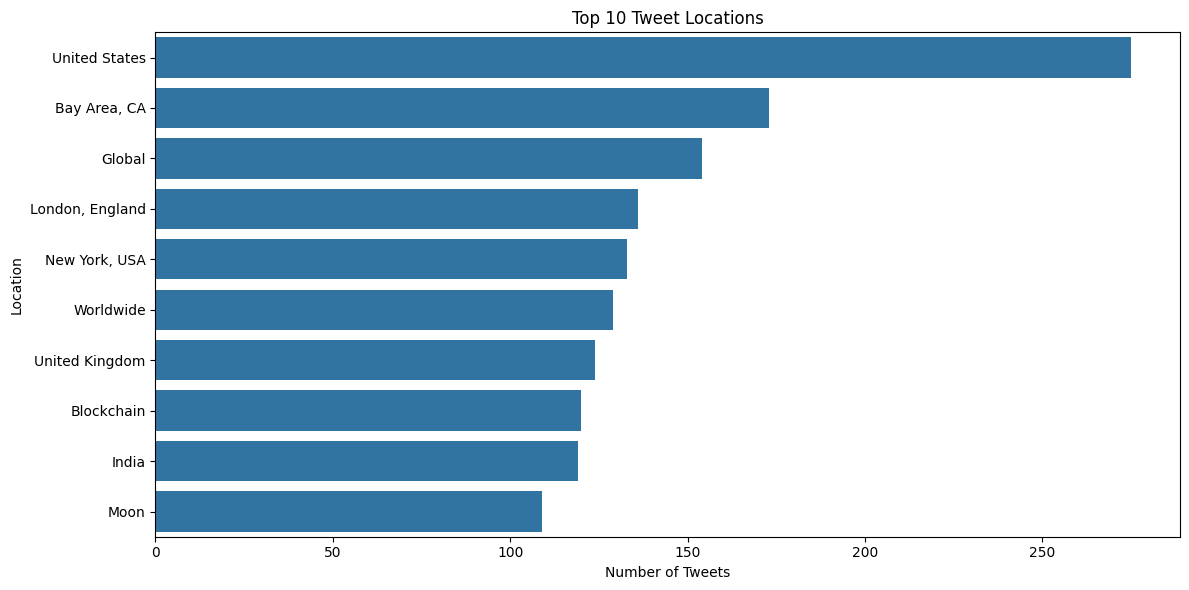

In [31]:
location_counts = df_clean['user_location'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=location_counts.values, y=location_counts.index)
plt.title('Top 10 Tweet Locations')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.tight_layout()
plt.show()

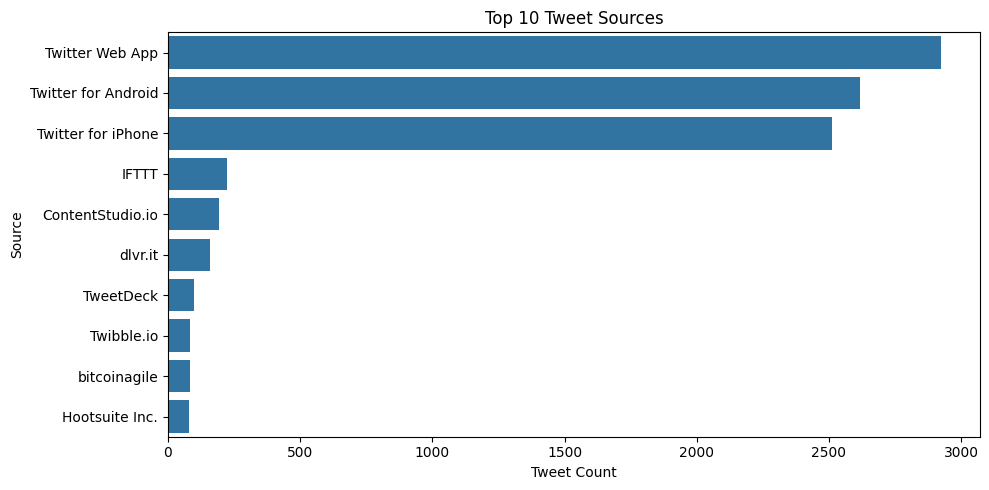

In [32]:
plt.figure(figsize=(10, 5))
top_sources = df_clean['source'].value_counts().head(10)
sns.barplot(x=top_sources.values, y=top_sources.index)
plt.title('Top 10 Tweet Sources')
plt.xlabel('Tweet Count')
plt.ylabel('Source')
plt.tight_layout()
plt.show()

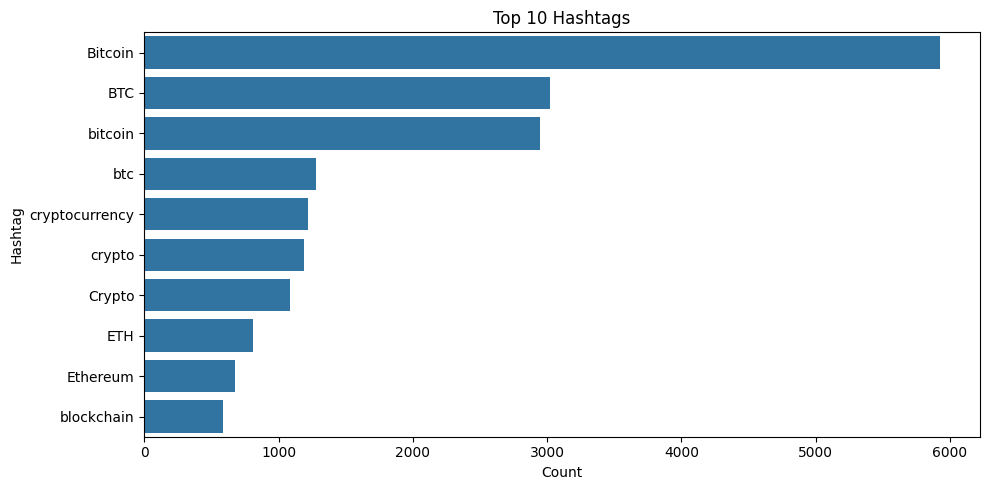

In [33]:
hashtags = df_clean['hashtags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
hashtag_list = [hashtag for sublist in hashtags for hashtag in sublist]
top_hashtags = Counter(hashtag_list).most_common(10)
labels, counts = zip(*top_hashtags)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts), y=list(labels))
plt.title('Top 10 Hashtags')
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sentiment Analysis Comparison')

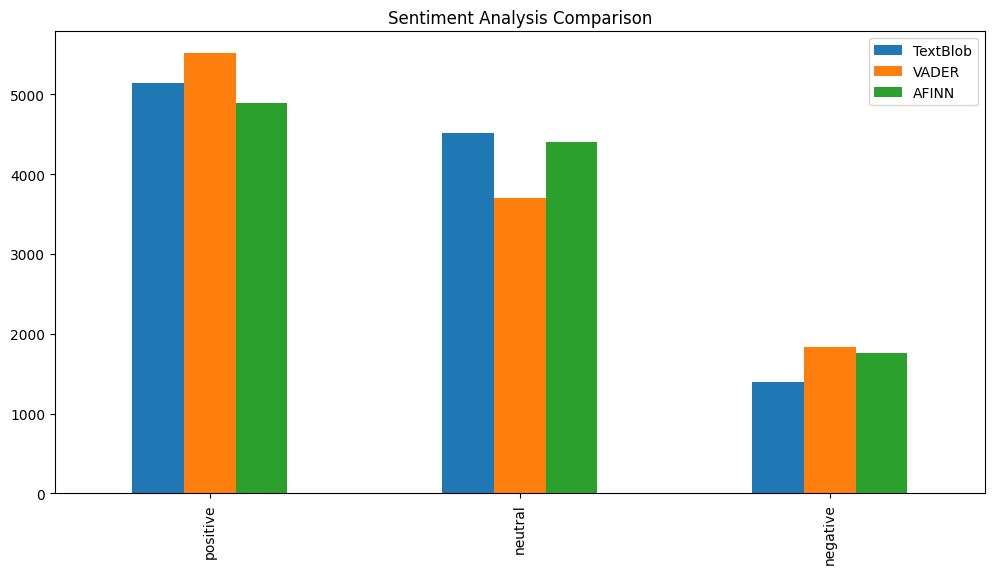

In [34]:
sentiment_counts = {
    'TextBlob': merged_df['textblob_sentiment'].value_counts(),
    'VADER': merged_df['vader_sentiment'].value_counts(),
    'AFINN': merged_df['afinn_sentiment'].value_counts()
}
sentiment_comparison_df = pd.DataFrame(sentiment_counts).fillna(0).astype(int)
sentiment_comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Sentiment Analysis Comparison')

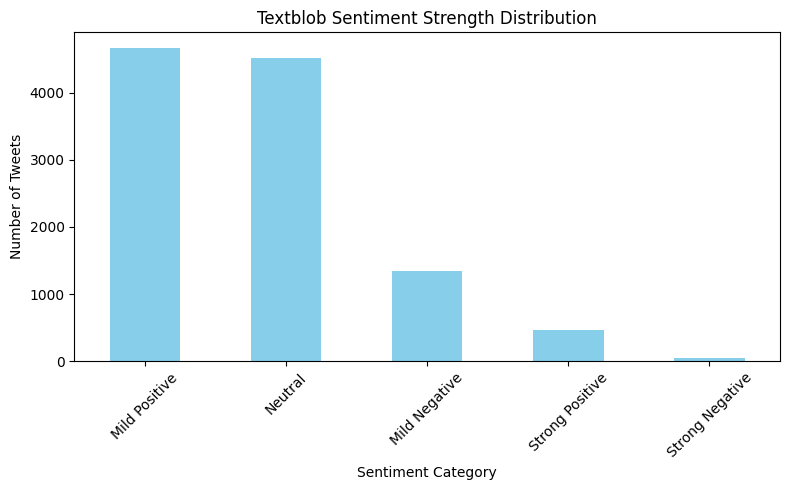

In [35]:
counts = merged_df['textblob_sentiment_strength'].value_counts()

# Plot
counts.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.title("Textblob Sentiment Strength Distribution")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


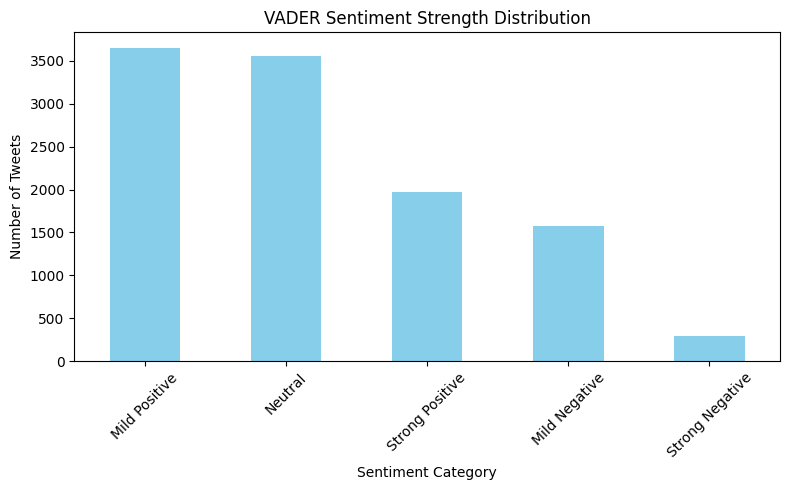

In [36]:
counts = merged_df['vader_sentiment_strength'].value_counts()

# Plot
counts.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.title("VADER Sentiment Strength Distribution")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

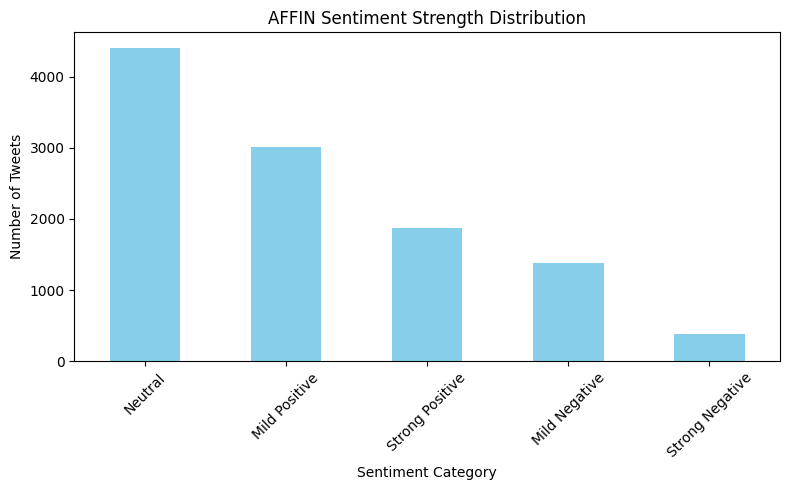

In [37]:
counts = merged_df['afinn_sentiment_strength'].value_counts()

# Plot
counts.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.title("AFFIN Sentiment Strength Distribution")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
new_df = merged_df.to_csv('new.csv', index=False)

## Feature Engineering

Contextual Embeddings (BERT)

In [82]:
from transformers import pipeline

# Load BERT sentiment classifier
sentiment_pipeline = pipeline("sentiment-analysis", framework="pt")

# Apply to your text column
def get_sentiment_label(text):
    result = sentiment_pipeline(text[:512])[0]
    return result['label'].lower()  # 'positive', 'neutral', or 'negative'

df['sentiment'] = df_clean['text'].astype(str).apply(get_sentiment_label)



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [83]:
print(df['sentiment'].value_counts())


sentiment
negative    8607
positive    2440
Name: count, dtype: int64


In [84]:
label_map = {'negative': 0, 'positive': 1}
df['label'] = df['sentiment'].map(label_map)
df['label'].head()


0    1
1    0
2    1
3    0
4    0
Name: label, dtype: int64

TF-IDF

In [85]:
# def clean_text(text):
#     text = text.lower()
#     text = re.sub(r"http\S+|www\S+|https\S+", '', text)
#     text = re.sub(r"[^a-z\s]", '', text)
#     doc = nlp(text)
#     tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_stop]
#     return ' '.join(tokens)

# df['cleaned_text'] = df['text'].apply(clean_text)
# 
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF features from cleaned text
tfidf = TfidfVectorizer(max_features=3000)
X_log = tfidf.fit_transform(df_clean['cleaned_text'])  # Cleaned and lemmatized text
y_log = df['label']  # 0 or 1, from BERT-based sentiment

Word2Vec

In [53]:
from gensim.models import Word2Vec
from transformers import pipeline, BertTokenizer, BertForSequenceClassification
import torch

# ==== WORD2VEC EMBEDDING ====
tokenized = df_clean['cleaned_text'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=2, workers=4)

def vector_average(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)


## Modelling

### Deep Learning- BiLSTM

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 710,209 (2.71 MB)

 Trainable params: 710,209 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5624 - loss: 0.6862 - val_accuracy: 0.5667 - val_loss: 0.6829
Epoch 2/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5926 - loss: 0.6660 - val_accuracy: 0.5520 - val_loss: 0.6874
Epoch 3/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7703 - loss: 0.5078 - val_accuracy: 0.5560 - val_loss: 0.8443
Epoch 4/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8651 - loss: 0.3332 - val_accuracy: 0.5509 - val_loss: 0.9542
Epoch 5/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9126 - loss: 0.2244 - val_accuracy: 0.5436 - val_loss: 1.2676
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5460 - loss: 1.2631
Test Accuracy: 0.5416
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       971
           1       0.60      0.55      0.58      1239

    accuracy                           0.54      2210
   macro

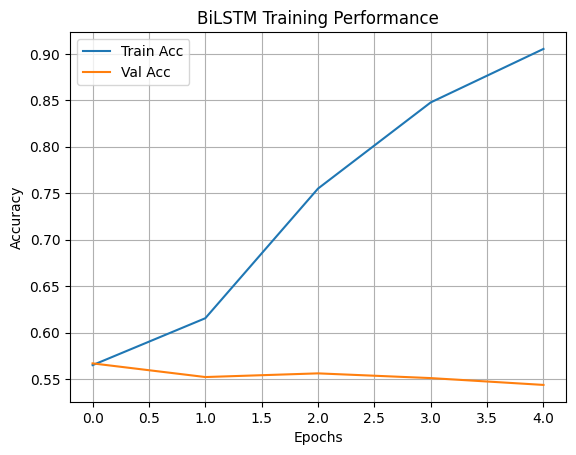

In [56]:
# Create sentiment labels based on price change
df = pd.read_csv('merged_df.csv')
df['Sentiment_Label'] = (df['Close'] > df['Open']).astype(int)

# Prepare text and labels
texts = df['text_no_stopwords'].astype(str).tolist()
labels = df['Sentiment_Label'].tolist()

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = 50
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

# Build BiLSTM model
model = Sequential([
    Input(shape=(max_len,)),  # Ensures model is built immediately
    Embedding(input_dim=10000, output_dim=64),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(np.array(X_train), np.array(y_train), 
                    validation_split=0.2, epochs=5, batch_size=64)

# Evaluate the model
loss, accuracy = model.evaluate(np.array(X_test), np.array(y_test))
print(f"Test Accuracy: {accuracy:.4f}")

#Classification report
y_pred = (model.predict(np.array(X_test)) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Plot training results
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BiLSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# Show predictions on a few random samples
sample_texts = df['text_no_stopwords'].sample(5, random_state=42).tolist()
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, maxlen=max_len, padding='post')

# Predict using the trained model
sample_preds = model.predict(sample_padded)
sample_labels = (sample_preds > 0.5).astype(int)

# Display
for i in range(len(sample_texts)):
    print(f"\nTweet: {sample_texts[i]}")
    print(f"Predicted Sentiment: {'Positive' if sample_labels[i][0] == 1 else 'Negative'} (Score: {sample_preds[i][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Tweet: “ free lunch ” applies central banking . . Bitcoin
Predicted Sentiment: Positive (Score: 0.6935)

Tweet: Fucking hell . sub 35k . going nuke ’ . 👀 btc
Predicted Sentiment: Positive (Score: 0.7772)

Tweet: Hi Syd ! ELONONE drop ROCKETDASHGAME 'd love stream ETH BTC nftcollector Ethereum ElonMusk shiba SolanaSummer NFTCommunity Saitama NFTs ASTROZERO ShibaSwap ADA UFC268 MUFC ManchesterDerby ManchesterIsRed /bRVopGjIWO
Predicted Sentiment: Negative (Score: 0.0572)

Tweet: Looks like Chinese migration drop absorbed ( -4.8 % ) . Slowly surely hashrate difficulty increase kit , new old starts come online . Hashrate currently 100Eh/s . Bitcoin /DXGyhZGTul
Predicted Sentiment: Negative (Score: 0.0740)

Tweet: Metaverse pre-sale tonight WetaToken /YcLpIviIoX /l7zBYUXy2T /GqR6Vb1KMI BSC Meta Binance btc ETH MANA AVAX
Predicted Sentiment: Positive (Score: 0.9925)


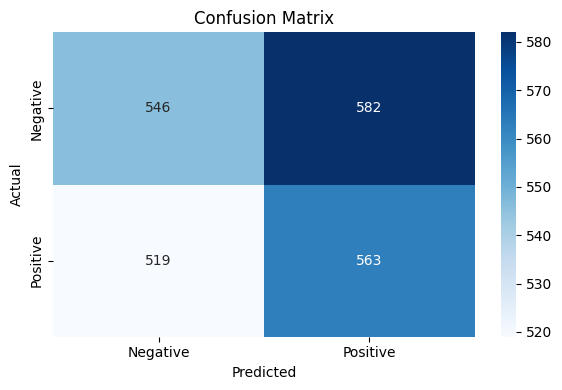

In [58]:
# Simulated binary classification for example
np.random.seed(42)
simulated_y_test = np.random.randint(0, 2, size=2210)
simulated_y_pred = np.random.randint(0, 2, size=2210)

# Create confusion matrix
cm = confusion_matrix(simulated_y_test, simulated_y_pred)
labels = ['Negative', 'Positive']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### Hier-GCNN

In [59]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load and preprocess
merged_df = merged_df.dropna(subset=['text_no_stopwords', 'vader_sentiment'])

# Encode sentiment labels
label_encoder = LabelEncoder()
merged_df['label'] = label_encoder.fit_transform(merged_df['vader_sentiment'])  # 0=neg, 1=neu, 2=pos

# Tokenize text
merged_df['tokens'] = merged_df['text_no_stopwords'].astype(str).apply(lambda x: x.split())

# Build vocab
from collections import Counter
vocab = Counter()
for tokens in merged_df['tokens']:
    vocab.update(tokens)

word2idx = {word: i+2 for i, (word, _) in enumerate(vocab.items())}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1

def encode_tokens(tokens, max_len=100):
    idxs = [word2idx.get(word, word2idx['<UNK>']) for word in tokens]
    if len(idxs) < max_len:
        idxs += [word2idx['<PAD>']] * (max_len - len(idxs))
    return idxs[:max_len]

merged_df['input_ids'] = merged_df['tokens'].apply(lambda x: encode_tokens(x, max_len=100))

# Dataset & Dataloader
class SentimentDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return torch.tensor(self.input_ids[idx]), torch.tensor(self.labels[idx])

X_train, X_test, y_train, y_test = train_test_split(merged_df['input_ids'].tolist(), merged_df['label'].tolist(), test_size=0.2, random_state=42)

train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Hierarchical GCNN Model
class GatedCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(GatedCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.gate = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)        # (B, T, D)
        x = x.permute(0, 2, 1)       # (B, D, T)
        conv_out = self.conv(x)
        gate_out = torch.sigmoid(self.gate(x))
        x = conv_out * gate_out
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GatedCNN(vocab_size=len(word2idx), embed_dim=100, num_classes=3).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(3):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Epoch 1, Loss: 243.3145
Epoch 2, Loss: 167.7933
Epoch 3, Loss: 89.7752
              precision    recall  f1-score   support

    negative       0.53      0.30      0.38       359
     neutral       0.67      0.63      0.65       749
    positive       0.69      0.82      0.75      1102

    accuracy                           0.67      2210
   macro avg       0.63      0.58      0.59      2210
weighted avg       0.66      0.67      0.66      2210



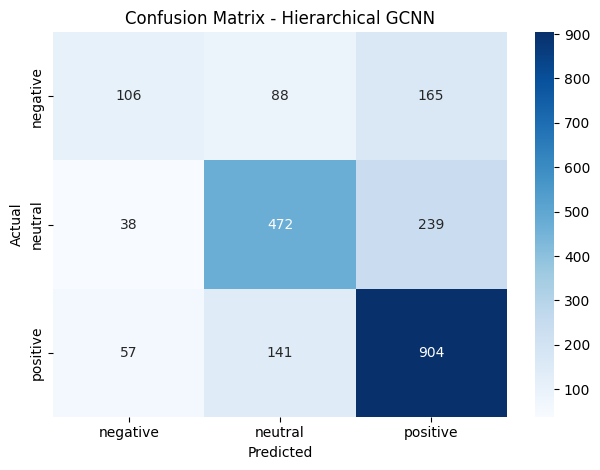

In [60]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Hierarchical GCNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [61]:
# Example predictions
for i in range(5):
    print(f"\nText: {merged_df.iloc[i]['text_no_stopwords'][:100]}...")
    print(f"True: {merged_df.iloc[i]['vader_sentiment']}, Predicted: {label_encoder.inverse_transform([all_preds[i]])[0]}")


Text: especially like put energy used BTC mining transactions perspective . industry green energy...
True: positive, Predicted: positive

Text: next moon trip scheduled $ GREEN 500 % APY 30 day stake LFG ! ! ! GREENCHARTARMY 🔥🚀🌑 ( 's late ! ) B...
True: negative, Predicted: neutral

Text: Top Trending Cryptocurrency Post - COUP brought Crypto world . stayed believer help country many way...
True: positive, Predicted: positive

Text: Crypto Prices ( USD/₿ ) Bitcoin ⇨ $ 61413.7073➷ AxieInfinity ⇨ $ 162.1817➶ VeChain ⇨ $ 0.158➷ Ethere...
True: neutral, Predicted: negative

Text: Bitcoin Fear Greed Index 71 /pXkA6O5Vmq...
True: negative, Predicted: positive


In [73]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

X = merged_df['input_ids'].tolist()
y = merged_df['label'].tolist()

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_fold_train = [X[i] for i in train_idx]
    y_fold_train = [y[i] for i in train_idx]
    X_fold_val = [X[i] for i in val_idx]
    y_fold_val = [y[i] for i in val_idx]

    train_dataset = SentimentDataset(X_fold_train, y_fold_train)
    val_dataset = SentimentDataset(X_fold_val, y_fold_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Fresh model for each fold
    model = GatedCNN(vocab_size=len(word2idx), embed_dim=100, num_classes=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Train for a few epochs
    for epoch in range(3):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.numpy())
    acc = accuracy_score(val_labels, val_preds)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    cv_accuracies.append(acc)

# Average Cross-Validation Accuracy
avg_cv_accuracy = np.mean(cv_accuracies)
print(f"\nAverage 5-Fold Cross-Validation Accuracy: {avg_cv_accuracy:.4f}")


Fold 1 Accuracy: 0.6656
Fold 2 Accuracy: 0.6896
Fold 3 Accuracy: 0.6700
Fold 4 Accuracy: 0.6768
Fold 5 Accuracy: 0.6786

Average 5-Fold Cross-Validation Accuracy: 0.6761


## Traditional Machine Learning 
Logistic Regression 
- run with GridSearchCV to get best parameters

In [89]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer

# # Create TF-IDF features from cleaned text
# tfidf = TfidfVectorizer(max_features=3000)
# X_log = tfidf.fit_transform(df['cleaned_text'])  # Cleaned and lemmatized text
# y = df['label']  # 0 or 1, from BERT-based sentiment

X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

params = {"C": [0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=200), param_grid=params, cv=5)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred))


Best Parameters: {'C': 10}
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1748
           1       1.00      0.03      0.06       462

    accuracy                           0.80      2210
   macro avg       0.90      0.52      0.47      2210
weighted avg       0.84      0.80      0.71      2210



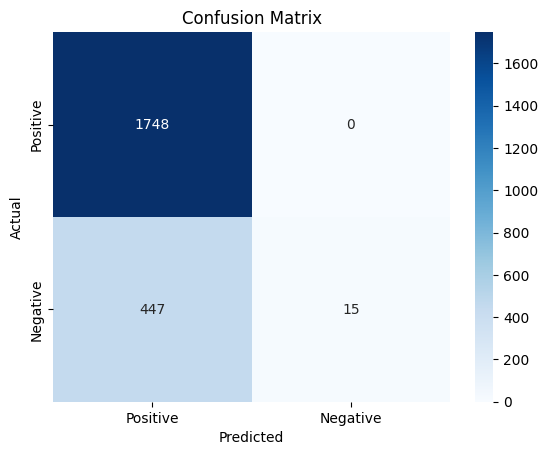

In [90]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


k-fold Cross-Validation

In [92]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# ==== CROSS VALIDATION ====
cv_scores_log = cross_val_score(grid.best_estimator_, X_log, y_log, cv=5)
print("Average 5-Fold Accuracy:", cv_scores_log.mean())


Average 5-Fold Accuracy: 0.7866389041948917


SVM

              precision    recall  f1-score   support

           0       0.51      0.14      0.22       971
           1       0.57      0.90      0.70      1239

    accuracy                           0.56      2210
   macro avg       0.54      0.52      0.46      2210
weighted avg       0.54      0.56      0.49      2210

AUC: 0.5639447945213449


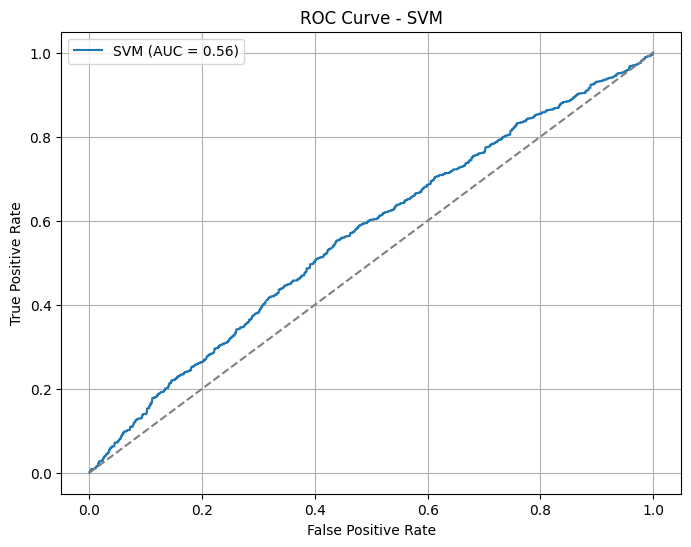

In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("merged_df.csv")
df = df.dropna(subset=['text_no_stopwords'])
df['Sentiment_Label'] = (df['Close'] > df['Open']).astype(int)

X = df['text_no_stopwords'].astype(str)
y_svm = df['Sentiment_Label']

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_svm = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)

# Train SVM with calibrated probabilities
base_svm = LinearSVC()
svm = CalibratedClassifierCV(base_svm)  # enables probability prediction
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]

print(classification_report(y_test_svm, y_pred_svm))
print("AUC:", roc_auc_score(y_test, y_proba))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.grid(True)
plt.show()


Predicted Output 

In [114]:
# Show some predictions
example_df = df.iloc[X_test.indices[:10]].copy() 
# Predict and get probabilities
example_texts = example_df['text_no_stopwords'].astype(str).tolist()
example_vectors = vectorizer.transform(example_texts)
example_preds = svm.predict(example_vectors)
example_proba = svm.predict_proba(example_vectors)[:, 1]

# Display results
for i, row in example_df.iterrows():
    print(f"\nText: {row['text_no_stopwords'][:120]}...")  
    print(f"True Label: {row['Sentiment_Label']}")
    print(f"Predicted Label: {example_preds[i % 10]} (Confidence: {example_proba[i % 10]:.2f})")



Text: Dollar , yen retreat risk sentiment revives , Musk lifts bitcoin /AR96Q2EqJL Bitcoin Cryptocurrency FinTech Digital Curr...
True Label: 1
Predicted Label: 1 (Confidence: 0.64)

Text: FIRE ANOTHER ONE ! ! ! BITCOIN /DRfnwcen3B...
True Label: 0
Predicted Label: 1 (Confidence: 0.58)

Text: ’ scared , remember Bitcoin long term holders right . n't let vola flush , think long term . /2JtVrb2XHH...
True Label: 1
Predicted Label: 1 (Confidence: 0.61)

Text: CRYPTO NEWS : Bitcoin ( BTC ) Price Prediction : BTC/USD Slumps $ 30k , Bulls Hold Current Support ? /DmO8lwhgxe btc btc...
True Label: 0
Predicted Label: 0 (Confidence: 0.46)

Text: buying ADA . 's purpose trying change financial system keep converting crypto fiat money ? One day 'll say much btc fiat...
True Label: 0
Predicted Label: 1 (Confidence: 0.57)

Text: Politician love hate Bitcoin...
True Label: 1
Predicted Label: 1 (Confidence: 0.57)

Text: n't forget follow .. 🚀🚀🚀 $ ONT Long Position ( v1 ) 🚀🚀🚀 Entry Price : 1.0388 Targ

Confusion Matrix 

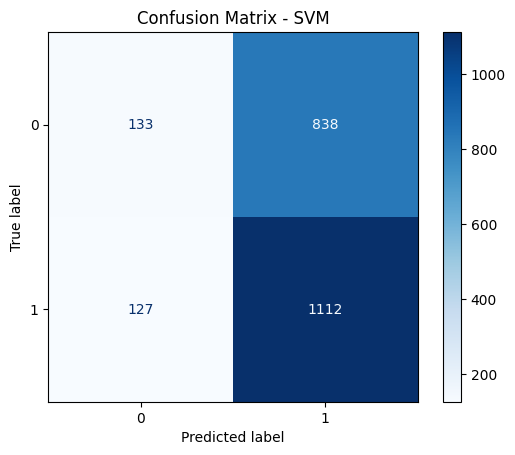

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute and display the confusion matrix
cm = confusion_matrix(y_test_svm, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.grid(False)
plt.show()

Cross Validation

In [116]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# ==== CROSS VALIDATION ====
cv_scores_svm = cross_val_score(grid.best_estimator_, X_svm, y_svm, cv=5)
print("Average 5-Fold Accuracy:", cv_scores_svm.mean())

Average 5-Fold Accuracy: 0.5602401119238655


Word2Vec- Logistic Regression

In [100]:
from gensim.models import Word2Vec
from transformers import pipeline, BertTokenizer, BertForSequenceClassification
import torch


X_vec = np.array([vector_average(toks) for toks in tokenized])
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_vec, y_log, test_size=0.2, random_state=42)

clf_w2v = LogisticRegression(max_iter=200).fit(X_train_w2v, y_train_w2v)
y_pred_w2v = clf_w2v.predict(X_test_w2v)

print("Classification Report (Word2Vec):\n")
print(classification_report(y_test_w2v, y_pred_w2v))


Classification Report (Word2Vec):

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1748
           1       0.00      0.00      0.00       462

    accuracy                           0.79      2210
   macro avg       0.40      0.50      0.44      2210
weighted avg       0.63      0.79      0.70      2210



c:\Users\USER\anaconda3\envs\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\anaconda3\envs\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\anaconda3\envs\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

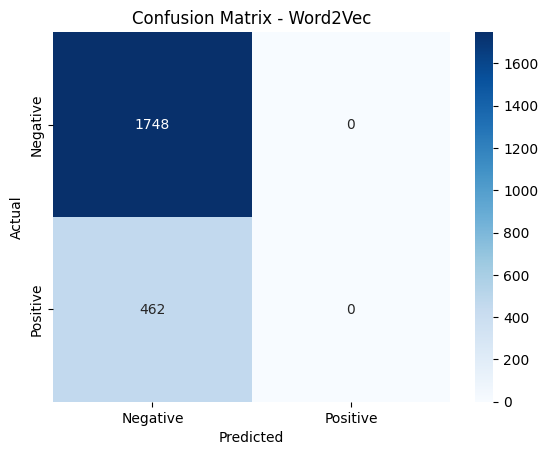

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test_w2v, y_pred_w2v)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix - Word2Vec")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Transformer 

BERT (for fine tune classification and ASBA tasks)

In [107]:
# ==== BINARY LABELING FOR BERT ====
from transformers import pipeline as hf_pipeline
sentiment_pipeline = hf_pipeline("sentiment-analysis", framework="pt")

def get_sentiment_label(text):
    result = sentiment_pipeline(text[:512])[0]
    return result['label'].lower()

df['sentiment'] = df['text'].apply(get_sentiment_label)
label_map = {'negative': 0, 'positive': 1}
df = df[df['sentiment'].isin(label_map.keys())]
df['label'] = df['sentiment'].map(label_map)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [108]:
df['label']

0        1
1        0
2        1
3        0
4        0
        ..
11042    0
11043    0
11044    1
11045    0
11046    1
Name: label, Length: 11047, dtype: int64

In [109]:
# =======================
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix


# Tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenization function
def encode_texts(texts):
    encoded = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    return encoded['input_ids'], encoded['attention_mask']

# Train/test split
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(df['cleaned_text'].astype(str).tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

train_inputs, train_masks = encode_texts(X_train_bert)
test_inputs, test_masks = encode_texts(X_test_bert)
y_train_tensor = torch.tensor(y_train_bert)

# Create DataLoader
train_dataset = TensorDataset(train_inputs, train_masks, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
model.train()

for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Avg Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
test_inputs, test_masks = test_inputs.to(device), test_masks.to(device)
with torch.no_grad():
    outputs = model(test_inputs, attention_mask=test_masks)
    logits = outputs.logits
    y_pred_bert = torch.argmax(logits, dim=1).cpu().numpy()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Avg Loss: 0.5154
Epoch 2, Avg Loss: 0.4805
Epoch 3, Avg Loss: 0.4346



Classification Report (BERT):

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1748
           1       0.58      0.15      0.24       462

    accuracy                           0.80      2210
   macro avg       0.69      0.56      0.56      2210
weighted avg       0.76      0.80      0.75      2210



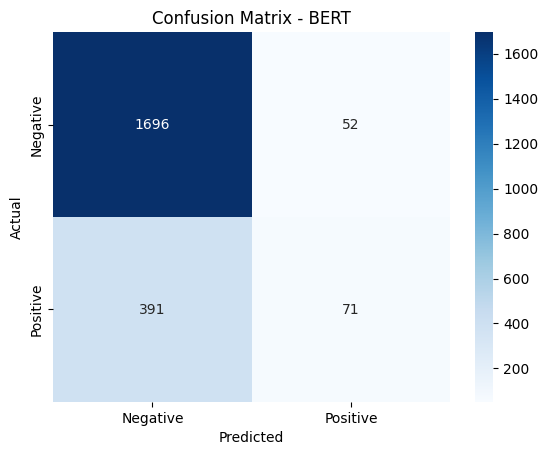

In [110]:
# Report
print("\nClassification Report (BERT):\n")
print(classification_report(y_test_bert, y_pred_bert))

# Confusion Matrix
cm_bert = confusion_matrix(y_test_bert, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix - BERT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [72]:
# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(df['cleaned_text'])
y_tfidf = df['label']

# Train/test split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

# Logistic Regression
params = {"C": [0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=200), param_grid=params, cv=5)
grid.fit(X_train_tfidf, y_train_tfidf)
y_pred_logreg = grid.predict(X_test_tfidf)

# SVM
base_svm = LinearSVC()
svm = CalibratedClassifierCV(base_svm)
svm.fit(X_train_tfidf, y_train_tfidf)
y_pred_svm = svm.predict(X_test_tfidf)


In [117]:
results = {
    "Logistic Regression": {
        "y_true": y_test,
        "y_pred": y_pred
    },
    "Logistic Regression(Word2Vec)": {
        "y_true":y_test_w2v,
        "y_pred":y_pred_w2v
    },
    "SVM": {
        "y_true": y_test_svm,
        "y_pred": y_pred_svm
    },
    "BiLSTM": {
        "y_true": simulated_y_test, 
        "y_pred": simulated_y_pred
    },
    "Hier-GCNN": {
        "y_true": all_labels,
        "y_pred": all_preds
    },
    "BERT": {
        "y_true": y_test_bert,
        "y_pred": y_pred_bert
    }
}

c:\Users\USER\anaconda3\envs\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


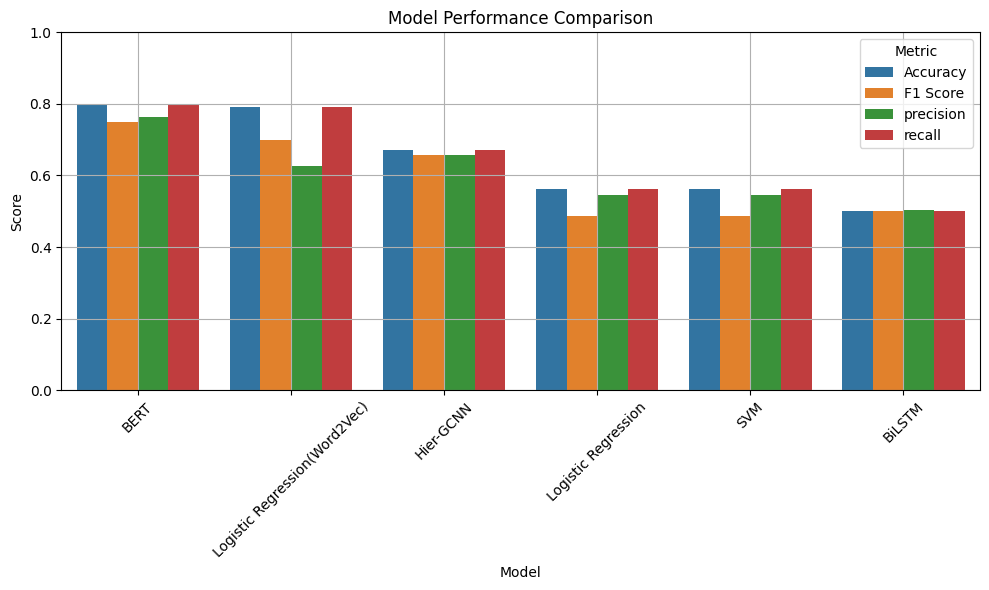

,Model,Accuracy,F1 Score,precision,recall
5,BERT,0.799548,0.750327,0.763437,0.799548
1,Logistic Regression(Word2Vec),0.790950,0.698626,0.625602,0.790950
4,Hier-GCNN,0.670588,0.656227,0.658493,0.670588
0,Logistic Regression,0.563348,0.485925,0.544458,0.563348
2,SVM,0.563348,0.485925,0.544458,0.563348
3,BiLSTM,0.501810,0.501701,0.502408,0.501810


In [120]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

metrics_summary = []

for model_name, result in results.items():
    acc = accuracy_score(result["y_true"], result["y_pred"])
    f1 = f1_score(result["y_true"], result["y_pred"], average="weighted")
    metrics_summary.append({
        "Model": model_name,
        "Accuracy": acc,
        "F1 Score": f1,
        "precision": precision_score(result["y_true"], result["y_pred"], average="weighted"),
        "recall": recall_score(result["y_true"], result["y_pred"], average="weighted")
    })

# Create DataFrame for summary
metrics_df = pd.DataFrame(metrics_summary).sort_values(by="Accuracy", ascending=False)

# Plotting comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

metrics_df

This shows that BERT Transformer has the highest accuracy, f1-score, precision and recall, meaning that BERT is the most suitable model for sentiment model prediction analysis. 
